In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
import glob

from src.utils import *
from src.forward_model import *

### Load in data

In [2]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Ground truth record path
gt_path = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_9/ground_truths')
gt_files = glob.glob(path.join(gt_path, '*'))

# Simulation output record path
record_dir = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_9/train')

# Output name prefix
sample_names = 'sample'

obj_dims = (648, 486)

In [3]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

### Load in TFRecord data

In [4]:
# TFRecord Utils
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _create_example(plane, sim):
    plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
    sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=sim.ravel()))
    feature = {
        'plane': plane_feature,
        'sim': sim_feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [5]:
raw_dataset = tf.data.TFRecordDataset(filenames=gt_files)
dataset = raw_dataset.map(_parse_function)

Text(0.5, 1.0, 'Simulated example')

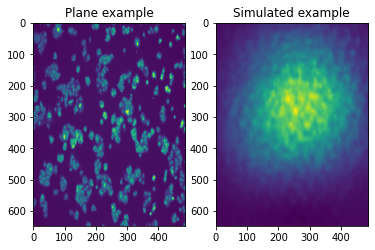

In [6]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.A_svd_2d(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

## Running simulations with forward model

In [ ]:
model = ForwardModel()

for i, sample in enumerate(dataset):
    plane = sample['plane'].numpy()
    sim = model.A_svd_2d(plane, weights, h).astype(np.float16)

    tf_example = _create_example(plane, sim)
    record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
    with tf.io.TFRecordWriter(record_file) as writer:
        writer.write(tf_example.SerializeToString())

    if i % 500 == 0:
        print('sim-%.5d processed' % i)

sim-00000 processed
